## Before Productionizing
---

- [ ] Verify Model: Make sure we stored the correct model to be put into production.
- [ ] Create/Get tests

#### Verify Model

In [1]:
pip install -i https://repository.sofi.com/artifactory/api/pypi/pypi/simple proto-utils

Looking in indexes: https://repository.sofi.com/artifactory/api/pypi/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys, os, json
sys.path.append('../..')
import pandas as pd
import pickle as pkl
import lightgbm as lgb
from tqdm import tqdm
import src.monitoring.monitoring as mntr
from smart_open import open
import src.monitoring.utils as mu

import matplotlib.pyplot as plt
plt.style.use("seaborn")

In [3]:
import warnings
import math
from tqdm import tqdm
import boto3
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None ## pd warning

from proto_utils import nested_proto_to_dict
from sofiproto.moneyfraud import customer_risk_v2_pb2
from read_protobuf import read_protobuf
from google.protobuf.json_format import MessageToDict, ParseDict 

from smart_open import open
import pickle as pkl
from rdsutils.post_implementation_testing import plot_score_dist, get_psi, get_overlap_and_diff
from rdsutils.post_implementation_testing import plot_difference, get_combined_dfs, get_feature_comparison_report

In [4]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)

def get_risk_groups_refitted(serie):
    return pd.cut(serie.round(), [300, 520, 550, 570, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)

In [5]:
incumbent_model_path = "s3://sofi-data-science/jxu/money-risk-models/models/customer_risk_target_no_giact_time_since_last_link.pkl"
refitted_model_path = "s3://sofi-data-science/jxu/money-risk-models/models/customer_risk_refit_20201231_wo_ind.pkl"

with open(incumbent_model_path, "rb") as f:
    incumbent_model = pkl.load(f)
    
with open(refitted_model_path, "rb") as f:
    refitted_model = pkl.load(f)

/home/ec2-user/anaconda3/envs/customer_risk/lib/python3.7/site-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/home/ec2-user/anaconda3/envs/customer_risk/lib/python3.7/site-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [9]:
df = pd.read_feather("../../data/combined_all_features/combined_1629343029.feather")

In [10]:
df = df[df.is_static]

In [37]:
# other setups
features = incumbent_model.feature_name_

df = mu.prep_customer_data(df)  # get is_active here
print(df[["sample_date", "is_active"]].value_counts())

df["pred_incumbent"] = incumbent_model.predict_proba(df[features])[:,1]
df["pred_refitted"] = refitted_model.predict_proba(df[features])[:,1]

df["score_incumbent"] = mu.scale_scores(df["pred_incumbent"])
df["score_refitted"] = mu.scale_scores(df["pred_refitted"])

df["rg_incumbent"] = get_risk_groups(df["score_incumbent"])
df["rg_refitted"] = get_risk_groups_refitted(df["score_refitted"])

sample_date  is_active
2021-07-01   False        794889
2021-06-01   False        757037
2021-07-01   True         163346
2021-06-01   True         151935
dtype: int64


In [16]:
june_df = df[df.sample_date==pd.to_datetime("2021-06-01")]
july_df = df[df.sample_date==pd.to_datetime("2021-07-01")]

#### Look at score distributions and RGs
---

new RG [deck](https://docs.google.com/presentation/d/1TEmUfvi7mJpm_ODxh2I0EClngfBRPWah54x5XzEB19g/edit#slide=id.g6d627d5dac_0_0)

<AxesSubplot:>

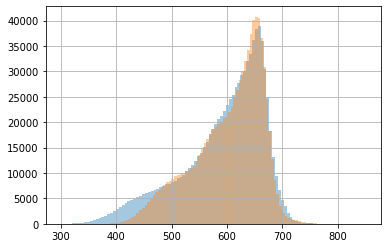

In [17]:
june_df.score_incumbent.hist(bins=100, alpha=0.4)
june_df.score_refitted.hist(bins=100, alpha=0.4)

<AxesSubplot:>

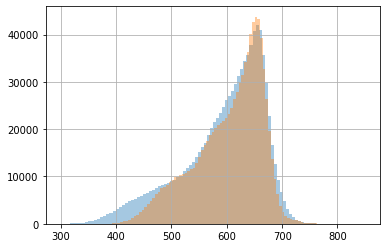

In [18]:
july_df.score_incumbent.hist(bins=100, alpha=0.4)
july_df.score_refitted.hist(bins=100, alpha=0.4)

### Make sure the score is correct
---

load 20210101 data for verification

In [27]:
test_path = 's3://sofi-data-science/jxu/monitoring/customer-risk-v1/archive/2021-06/test_df_2021-06.parquet'
test_df = pd.read_parquet(test_path)

In [28]:
test_df.shape

(4762099, 91)

<AxesSubplot:>

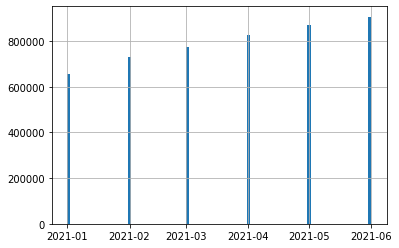

In [29]:
test_df.sample_date.hist(bins=100)

In [35]:
monitoring_dates = ["2021-01-01", "2021-02-01", "2021-03-01"]

In [32]:
test_df = mu.prep_customer_data(test_df)

test_df["pred_incumbent"] = incumbent_model.predict_proba(test_df[features])[:,1]
test_df["pred_refitted"] = refitted_model.predict_proba(test_df[features])[:,1]

test_df["score_incumbent"] = mu.scale_scores(test_df["pred_incumbent"])
test_df["score_refitted"] = mu.scale_scores(test_df["pred_refitted"])

test_df["rg_incumbent"] = get_risk_groups(test_df["score_incumbent"])
test_df["rg_refitted"] = get_risk_groups_refitted(test_df["score_refitted"])

In [36]:
for dt_str in tqdm(monitoring_dates):
    dt = pd.to_datetime(dt_str)
    df_ = test_df[test_df.is_static & (test_df.sample_date == dt)]
    pred_cols = ["fico_adjusted_pred", "fraud_score_2", "score_incumbent", "score_refitted"]
    report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
    display(dt)
    display(report)

  0%|          | 0/3 [00:00<?, ?it/s]

Timestamp('2021-01-01 00:00:00')

,auc,ap,ks
fico_adjusted_pred,64.85,1.16,25.62
fraud_score_2,67.46,1.91,27.43
score_incumbent,68.60,10.03,23.52
score_refitted,77.82,18.33,39.22


 33%|███▎      | 1/3 [00:04<00:08,  4.37s/it]

Timestamp('2021-02-01 00:00:00')

,auc,ap,ks
fico_adjusted_pred,64.48,1.06,24.75
fraud_score_2,67.33,1.79,26.98
score_incumbent,67.09,10.21,21.66
score_refitted,75.42,16.02,35.87


 67%|██████▋   | 2/3 [00:09<00:04,  4.64s/it]

Timestamp('2021-03-01 00:00:00')

,auc,ap,ks
fico_adjusted_pred,65.10,0.96,25.20
fraud_score_2,66.54,1.33,25.56
score_incumbent,64.66,8.01,18.84
score_refitted,72.07,12.32,30.09


100%|██████████| 3/3 [00:14<00:00,  4.78s/it]


### Build Tests
---

Three options
* get data from staging and measure against dev env
* ping endpoint with data and compare results
* after model deployed, measure performance behavior

#### Get data from staging
---

In [19]:
import pickle, sys, os, boto3, botocore
import numpy as np
import pandas as pd
import mdsutils

sys.path.append('/home/ec2-user/SageMaker/machine-learning/ml-deploys/customer-risk-v2/web/')

from sofiproto.moneyfraud import customer_risk_v2_pb2
from read_protobuf import read_protobuf
from multiprocessing import Pool, cpu_count
from collections import defaultdict

In [ ]:
def download_user_input(proxy_id):
    if not isinstance(proxy_id, str): return 
    req_path = 'data-science-engineering-machine-learning-customer-risk-v2/' + proxy_id + '/request'

    try:
        prbf = s3.get_object(Bucket='machine-learning-proxy.sofi.com', Key=req_path)["Body"].read()
        df_row = read_protobuf(prbf, customer_risk_v2_pb2.CustomerRiskInputV2())
        row_dict = df_row.to_dict('records')[0]
        row_dict["proxy_id"] = proxy_id
        return row_dict

    except botocore.exceptions.ClientError:
        pass
        
def download_customer_prod_data(output_path, debug=False): 
    
    # last record
    money_user_query = f"""
    with df_tmp as
        (select party_id, created_dt, updated_dt, last_checked_date,
            max(last_checked_date) over (partition by party_id) last_checked_date_max,
            json_extract(risk_group_decision_info, '$.newRiskGroup') as risk_group,
            json_extract(json_extract(risk_group_decision_info, '$.decisionContext'), '$.requestSource') as request_source,
            json_extract(json_extract(json_extract(risk_group_decision_info, '$.decisionContext'), '$.customerModelResult'), '$.modelScore') as model_score,
            json_extract(json_extract(json_extract(risk_group_decision_info, '$.decisionContext'), '$.customerModelResult'), '$.decisionRuleDetails') as model_decision_rule_details,
            json_extract(json_extract(json_extract(risk_group_decision_info, '$.decisionContext'), '$.customerModelResult'), '$.customerModelRiskGroup') as mcustomer_model_risk_groupodel_score,
            json_extract(json_extract(json_extract(risk_group_decision_info, '$.decisionContext'), '$.customerModelResult'), '$.machineLearningProxyId') as proxy_id,
            json_extract(json_extract(risk_group_decision_info, '$.decisionContext'), '$.riskGroupEvaluationMethod') as risk_group_evaluation_method,
            COALESCE (CAST(json_extract(json_extract(risk_group_decision_info, '$.decisionContext'), '$.partnerName') as VARCHAR), 'SOFI') as partner_name
        from datalake_production_money_users.risk_group_history)  -- if wanna debug, set limit here
    select * from df_tmp
    where last_checked_date_max = last_checked_date;
    """
        
    athena = mdsutils.AthenaClient(database='datalake_production_money_users')
    print("querying money user data...")
    money_users_df = athena.query_to_df(money_user_query)
    
    if debug:
        print("debugging mode on")
        money_users_df = money_users_df.head(1000)
    
    print("some data processing...")
    money_users_df.dropna(axis = 0, subset = ['proxy_id'], inplace = True)
    money_users_df['proxy_id'] = money_users_df['proxy_id'].apply(lambda x: x[59:].strip('/').strip('"'))
    money_users_df.dropna(axis = 0, subset = ['proxy_id'], inplace = True)

    # filter by date? If we are only monitoring new account, need to filter by created_dt
#     money_users_df.created_dt = pd.to_datetime(money_users_df.created_dt)
#     money_users_df = money_users_df[money_users_df.created_dt > pd.to_datetime(last_monitoring_date)]

    num_cores = cpu_count()
    with Pool(cpu_count()) as p:
        ret_list = p.map(download_user_input, 
                         [row["proxy_id"] 
                          for _, row in money_users_df.iterrows()])

    # this was breaking the pipeline
    ret_list = list(filter(lambda x: x is not None, ret_list))
    ret_df = pd.DataFrame(ret_list)
    ret_df = ret_df[~ret_df.proxy_id.isna()]
    full_df = money_users_df.merge(ret_df, how = 'left', on = 'proxy_id')
    full_df = preprocess(full_df)
    
    full_df.to_parquet(output_path)


In [ ]:
query = f"""
    with df_tmp as
        (select party_id, created_dt, updated_dt, last_checked_date,
            max(last_checked_date) over (partition by party_id) last_checked_date_max,
            json_extract(risk_group_decision_info, '$.newRiskGroup') as risk_group,
            json_extract(json_extract(risk_group_decision_info, '$.decisionContext'), '$.requestSource') as request_source,
            json_extract(json_extract(json_extract(risk_group_decision_info, '$.decisionContext'), '$.customerModelResult'), '$.modelScore') as model_score,
            json_extract(json_extract(json_extract(risk_group_decision_info, '$.decisionContext'), '$.customerModelResult'), '$.decisionRuleDetails') as model_decision_rule_details,
            json_extract(json_extract(json_extract(risk_group_decision_info, '$.decisionContext'), '$.customerModelResult'), '$.customerModelRiskGroup') as mcustomer_model_risk_groupodel_score,
            json_extract(json_extract(json_extract(risk_group_decision_info, '$.decisionContext'), '$.customerModelResult'), '$.machineLearningProxyId') as proxy_id,
            json_extract(json_extract(risk_group_decision_info, '$.decisionContext'), '$.riskGroupEvaluationMethod') as risk_group_evaluation_method,
            COALESCE (CAST(json_extract(json_extract(risk_group_decision_info, '$.decisionContext'), '$.partnerName') as VARCHAR), 'SOFI') as partner_name
        from datalake_production_money_users.risk_group_history)  -- if wanna debug, set limit here
    select * from df_tmp
    where last_checked_date_max = last_checked_date;
    """

athena = mdsutils.AthenaClient(database='datalake_production_money_users')
print("querying money user data...")
money_users_df = athena.query_to_df(money_user_query)

#### Ping Endpoint
---

In [6]:
prod_path = f"s3://sofi-data-science/jxu/data_dump/money_customer_risk/20210916-dev-prod-alignment/prod.parquet"
dev_path = "s3://sofi-data-science/jxu/data_dump/money_customer_risk/20210928-fl-analysis/customer-risk-dev-20210915-static.parquet"

prod_df = pd.read_parquet(prod_path)
dev_df = pd.read_parquet(dev_path)

In [7]:
sample_date = "2021-09-15"
prod_df["last_checked_date"] = pd.to_datetime(prod_df["last_checked_date"])
prod_df["sample_date"] = prod_df["last_checked_date"].dt.date
prod_df = prod_df[prod_df["sample_date"]==pd.Timestamp(sample_date)]
dev_df = dev_df[dev_df.is_static & (dev_df["sample_date"]==pd.Timestamp(sample_date))]

In [8]:
prod_df.shape, dev_df.shape

((1129952, 57), (1119646, 91))

In [9]:
prod_df.sample_date.value_counts(), dev_df.sample_date.value_counts()

(2021-09-15    1129952
 Name: sample_date, dtype: int64,
 2021-09-15    1119646
 Name: sample_date, dtype: int64)

In [10]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)

def get_risk_groups_refitted(serie):
    return pd.cut(serie.round(), [300, 520, 550, 570, 600, 850],  # [300, 520, 550, 570, 590, 850]
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)

#### Protobuf

In [24]:
runtime_client = boto3.client('runtime.sagemaker')

In [11]:
# encode to protobuf

In [46]:
# setup
features = incumbent_model.feature_name_
exclude = ['transaction_code_encoded', 'all7120_default_encoded', 'bcc7120_default_encoded']
cols = [col for col in features + ["transaction_code"] if col not in exclude]

prod_df["user_id"] = prod_df["party_id"]
# input
dev_df_ = mu.preprocess(dev_df)
prod_df_ = mu.preprocess(prod_df)

In [47]:
%%time
# dev
dev_df_["pred_dev"] = refitted_model.predict_proba(dev_df_[features])[:,1]
dev_df_["score_dev"] = mu.scale_scores(dev_df_["pred_dev"])

# prod
prod_df_["pred_dev"] = refitted_model.predict_proba(prod_df_[features])[:,1]
prod_df_["score_dev"] = mu.scale_scores(prod_df_["pred_dev"])

# incumbent
dev_df_["incumbent_model_score_dev"] = incumbent_model.predict_proba(dev_df_[features])[:,1]
dev_df_["incumbent_model_score_dev"] = mu.scale_scores(dev_df_["incumbent_model_score_dev"])

prod_df_["incumbent_model_score_dev"] = incumbent_model.predict_proba(prod_df_[features])[:,1]
prod_df_["incumbent_model_score_dev"] = mu.scale_scores(prod_df_["incumbent_model_score_dev"])

CPU times: user 10min 57s, sys: 435 ms, total: 10min 57s
Wall time: 10.5 s


In [48]:
%%time

# dev
block_size = 10000
n_blocks = math.ceil(len(dev_df_)//block_size)
scores = []
for i in tqdm(range(n_blocks+1)):
    start = i*block_size
    end = min(len(dev_df_), (i+1)*block_size)
    df_block = dev_df_.iloc[start:end]
    if len(df_block) == 0:
        break
    
    # encode input
    inp = {'input': df_block[cols]}
    df_dict = {}
    for name in inp:
        df_dict[name] = [{k:v for k,v in m.items() if pd.notnull(v)} for m in inp[name].to_dict(orient='rows')]  

    proto = ParseDict(df_dict, customer_risk_v2_pb2.CustomerRiskInputV2(), ignore_unknown_fields=True)


    # get score
    response = runtime_client.invoke_endpoint(EndpointName='enhanced-validation-machine-learning-customer-risk-v2',
                                              ContentType='application/octet-stream', Accept='application/octet-stream',
                                              Body=proto.SerializeToString())
    scores_ = nested_proto_to_dict(response["Body"].read(), customer_risk_v2_pb2.CustomerRiskOutputV2())["score"]
    scores.extend(scores_.values.flatten().tolist())
    
dev_df_["score_prod"] = scores

100%|██████████| 112/112 [04:49<00:00,  2.59s/it]


CPU times: user 2min 35s, sys: 139 ms, total: 2min 35s
Wall time: 4min 50s


In [49]:
%%time

# prod
block_size = 10000
n_blocks = math.ceil(len(prod_df_)//block_size)
scores = []
for i in tqdm(range(n_blocks+1)):
    start = i*block_size
    end = min(len(prod_df_), (i+1)*block_size)
    df_block = prod_df_.iloc[start:end]
    if len(df_block) == 0:
        break
    
    # encode input
    inp = {'input': df_block[cols]}
    df_dict = {}
    for name in inp:
        df_dict[name] = [{k:v for k,v in m.items() if pd.notnull(v)} for m in inp[name].to_dict(orient='rows')]  

    proto = ParseDict(df_dict, customer_risk_v2_pb2.CustomerRiskInputV2(), ignore_unknown_fields=True)


    # get score
    response = runtime_client.invoke_endpoint(EndpointName='enhanced-validation-machine-learning-customer-risk-v2',
                                              ContentType='application/octet-stream', Accept='application/octet-stream',
                                              Body=proto.SerializeToString())
    scores_ = nested_proto_to_dict(response["Body"].read(), customer_risk_v2_pb2.CustomerRiskOutputV2())["score"]
    scores.extend(scores_.values.flatten().tolist())
    
prod_df_["score_prod"] = scores

100%|██████████| 113/113 [04:52<00:00,  2.59s/it]


CPU times: user 2min 39s, sys: 252 ms, total: 2min 39s
Wall time: 4min 52s


##### Scores align at 5 decimal places between prod and dev

In [50]:
# dev_df_["score_prod_rounded"] = dev_df_["score_prod"].round(5)
# dev_df_["score_dev_rounded"] = dev_df_["score_dev"].round(5)

In [51]:
((dev_df_["score_prod"] - dev_df_["score_dev"]).abs() < 1e-5).value_counts()

True    1119646
dtype: int64

In [52]:
((prod_df_["score_prod"] - prod_df_["score_dev"]).abs() < 1e-5).value_counts()

True    1129952
dtype: int64

In [53]:
# ((dev_df_["score_prod_rounded"] - dev_df_["score_dev_rounded"]).abs() < 1e-5).value_counts()

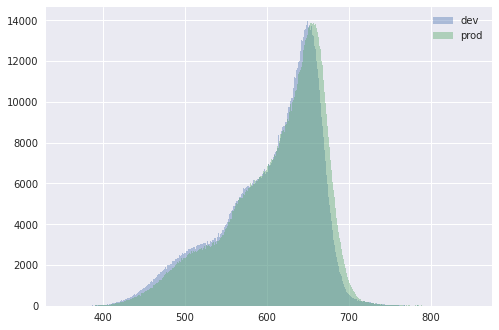

In [94]:
# 9/15
dev_df_.score_dev.hist(bins=400, alpha=0.4, label="dev")
prod_df_.score_prod.hist(bins=400, alpha=0.4, label="prod")
plt.legend()
plt.show()

In [55]:
combined_df = get_combined_dfs(dev_df_, prod_df_, index_col="user_id")  # dev-exp, prod->act
df_ = combined_df[["user_id", "business_account_number_exp", 
                   "score_prod_exp", "score_prod_act",
                   "score_dev_exp", "score_dev_act",
                   "incumbent_model_score_dev_exp",
                   "incumbent_model_score_dev_act"]]
df_["score_dev_data_prod_model"] = df_["score_prod_exp"]
df_["score_dev_data_dev_model"] = df_["score_dev_exp"]
df_["score_prod_data_prod_model"] = df_["score_prod_act"]
df_["score_prod_data_dev_model"] = df_["score_dev_act"]
df_["incumbent_model_dev_data"] = df_["incumbent_model_score_dev_exp"]
df_["incumbent_model_prod_data"] = df_["incumbent_model_score_dev_act"]

In [56]:
dev_df_.shape, prod_df_.shape, df_.shape

((1119646, 98), (1129952, 62), (1109925, 14))

#### Custom Tests

In [57]:
test_df = pd.read_csv("../../artifacts/archive-2020/post-implementation-testing/custom-tests/edge-case-performance.csv",
                      index_col=0)

In [58]:
features = incumbent_model.feature_name_
exclude = ['transaction_code_encoded', 'all7120_default_encoded', 'bcc7120_default_encoded']
cols = [col for col in features + ["transaction_code"] if col not in exclude]

In [59]:
# encode input
inp = {'input': mu.preprocess(test_df[cols])}
df_dict = {}
for name in inp:
    df_dict[name] = [{k:v for k,v in m.items() if pd.notnull(v)} for m in inp[name].to_dict(orient='rows')]  

proto = ParseDict(df_dict, customer_risk_v2_pb2.CustomerRiskInputV2(), ignore_unknown_fields=True)


# get score
response = runtime_client.invoke_endpoint(EndpointName='enhanced-validation-machine-learning-customer-risk-v2',
                                          ContentType='application/octet-stream', Accept='application/octet-stream',
                                          Body=proto.SerializeToString())
scores = nested_proto_to_dict(response["Body"].read(), customer_risk_v2_pb2.CustomerRiskOutputV2())["score"]
test_df["model_score"] = scores.values.flatten()

In [60]:
# dev
test_df["pred_dev"] = refitted_model.predict_proba(mu.preprocess(test_df)[features])[:,1]
test_df["dev_score"] = mu.scale_scores(test_df["pred_dev"])

In [61]:
# custom tests
test_df["dev_score"].equals(test_df["model_score"])

True

In [92]:
test_df.head()

,model_score,dev_score,first_deposit_amount,vantage_score,bcc7120,email_risk_score,fraud_score_2,name_email_correlation,transaction_as_pct_of_balance,mean_account_balance_30d,...,credit_card_loan_amount,fraud_score_1,age_money_account,transaction_code,borrower_id,type,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded,pred_dev
0,510.800736,510.800736,100.0,709.0,86.0,0.113,0.190,0.9871,-0.000736,3526.250800,...,10298.0,0.0153,46.0,POSDW,8068974.0,regular,1,-1.0,-1.0,0.019234
1,536.880061,536.880061,100.0,768.0,8.0,0.043,0.288,0.9952,750.000000,0.310000,...,183631.0,0.0215,4.0,ACHDDIN,8800403.0,regular,4,-1.0,-1.0,0.043718
2,474.113651,474.113651,300.0,793.0,15.0,0.182,0.227,0.9959,-0.911184,789.780000,...,1805.0,0.0355,311.0,ACHDW,1511678.0,regular,5,-1.0,-1.0,0.005927
3,486.510391,486.510391,5000.0,726.0,68.0,0.467,0.163,0.9946,0.016916,8773.400000,...,16298.0,0.0221,72.0,DDCK,7627983.0,regular,10,-1.0,-1.0,0.008836
4,538.522072,538.522072,150.0,638.0,91.0,0.195,0.667,0.9525,-0.128694,318.542308,...,1365.0,0.0508,83.0,ACHDWIN,8234793.0,regular,3,-1.0,-1.0,0.046001


In [62]:
s3_dir = "s3://sofi-data-science/jxu/data_dump/money_customer_risk/20210931-refitted-model-to-prod-v2/"
dev_df_.to_parquet(os.path.join(s3_dir, "dev-20210915-scored.parquet"))
prod_df_.to_parquet(os.path.join(s3_dir, "prod-20210915-scored.parquet"))
combined_df.to_parquet(os.path.join(s3_dir, "dev-prod-scored-combined_all_cols.parquet"))
df_.to_parquet(os.path.join(s3_dir, "dev-prod-scored-combined.parquet"))
test_df.to_csv(os.path.join(s3_dir, "custom-test.csv"))

#### Checkpoint
---

In [6]:
s3_dir = "s3://sofi-data-science/jxu/data_dump/money_customer_risk/20210931-refitted-model-to-prod-v2/"
dev_df_ = pd.read_parquet(os.path.join(s3_dir, "dev-20210915-scored.parquet"))
prod_df_ = pd.read_parquet(os.path.join(s3_dir, "prod-20210915-scored.parquet"))
df_ = pd.read_parquet(os.path.join(s3_dir, "dev-prod-scored-combined.parquet"))
combined_df = pd.read_parquet(os.path.join(s3_dir, "dev-prod-scored-combined_all_cols.parquet"))
test_df = pd.read_csv(os.path.join(s3_dir, "custom-test.csv"), index_col=0)

In [8]:
(df_.score_dev_data_prod_model - df_.score_dev_data_dev_model).value_counts()

 0.000000e+00    1109836
-1.136868e-13         43
 1.136868e-13         24
-5.684342e-14         13
 5.684342e-14          9
dtype: int64

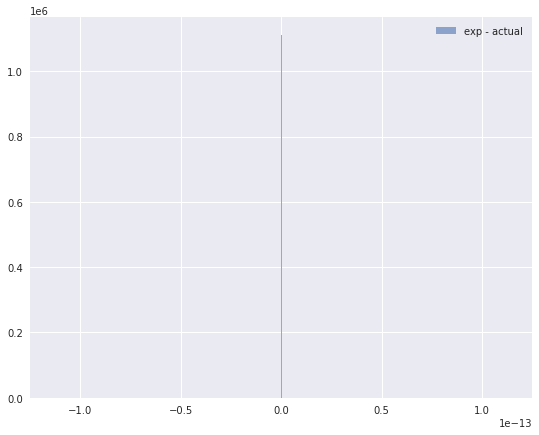

In [9]:
fig = plot_difference(df_.score_dev_data_prod_model, df_.score_dev_data_dev_model, bins=1000)
plt.show()

In [10]:
(df_.score_prod_data_prod_model - df_.score_prod_data_dev_model).value_counts()

 0.000000e+00    1109831
-1.136868e-13         42
 1.136868e-13         28
 5.684342e-14         22
-5.684342e-14          2
dtype: int64

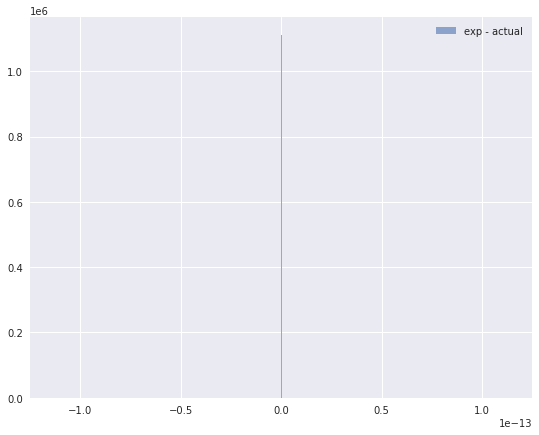

In [11]:
fig = plot_difference(df_.score_prod_data_prod_model, df_.score_prod_data_dev_model, bins=1000)
plt.show()

the differences is on the scale of rounding error.

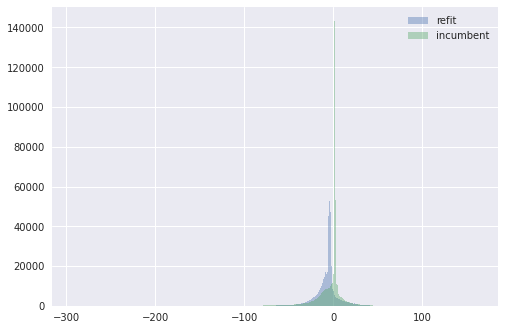

In [12]:
nbins = 1000
(df_.score_dev_data_dev_model - df_.score_prod_data_prod_model).hist(bins=nbins, alpha=0.4, label="refit")
(df_.incumbent_model_dev_data - df_.incumbent_model_prod_data).hist(bins=nbins, alpha=0.4, label="incumbent")
plt.legend()
plt.show()

The score differences are calculated using dev - prod model scores, which mean a negative score indicates user obtains higher score in production than that in development. Does this result in a shift up in user scores?

In [13]:
# first take a look at rmse
display(math.sqrt(((df_.score_dev_data_dev_model - df_.score_prod_data_prod_model)**2).mean()),
       math.sqrt(((df_.incumbent_model_dev_data - df_.incumbent_model_prod_data)**2).mean()))

16.60630507200601

17.905631182937572

In [14]:
features = refitted_model.feature_name_

In [15]:
dev_df_["model_score"] = dev_df_["score_dev"]
prod_df_["model_score"] = prod_df_["score_prod"]
psi_cols = features + ["model_score"]

In [16]:
# how about psi?
# score on all users
psi_tbl_all = get_psi(dev_df_[psi_cols], 
                       prod_df_[psi_cols]).round(3)

# score on shared users
col_dev = [f+"_exp" for f in features] + ["score_dev_exp"]
col_prod = [f+"_act" for f in features] + ["score_prod_act"]

def clean_df(df, cols):
    df = df[cols]
    df.columns = features + ["model_score"]
    return df

dev_df_aligned = clean_df(combined_df, col_dev)
prod_df_aligned = clean_df(combined_df, col_prod)

psi_tbl_shared = get_psi(dev_df_aligned,
                         prod_df_aligned).round(3)

In [17]:
psi_tbl_all.head()

,feature,psi
15,nr_past_transactions,0.559
6,transaction_as_pct_of_balance,0.111
38,transaction_code_encoded,0.059
26,time_since_last_transaction,0.028
41,model_score,0.023


In [18]:
psi_tbl_shared.head()

,feature,psi
15,nr_past_transactions,0.547
6,transaction_as_pct_of_balance,0.106
38,transaction_code_encoded,0.065
26,time_since_last_transaction,0.028
41,model_score,0.024


#### Risk Group Distributions
---

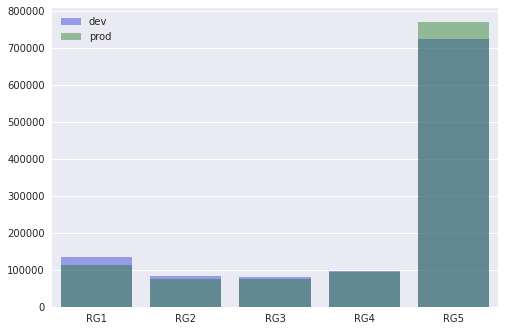

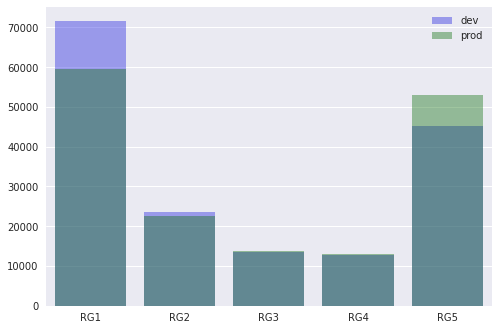

In [19]:
import seaborn as sns

# dev vs prod
dev_df_["rg_refitted"] = get_risk_groups_refitted(dev_df_["model_score"])
prod_df_["rg_refitted"] = get_risk_groups_refitted(prod_df_["model_score"])

freqs = dev_df_["rg_refitted"].value_counts().sort_index()
sns.barplot(freqs.index, freqs.values, alpha=0.4, label="dev", color="b")

freqs = prod_df_["rg_refitted"].value_counts().sort_index()
sns.barplot(freqs.index, freqs.values, alpha=0.4, label="prod", color="g")

plt.legend()
plt.show()

# how about the active group?

active_ids = dev_df_[
        (dev_df_.nr_past_transactions > 0) & (dev_df_.nr_transactions_30d > 0)
    ].user_id.unique()

freqs = dev_df_[dev_df_.user_id.isin(active_ids)]["rg_refitted"].value_counts().sort_index()
sns.barplot(freqs.index, freqs.values, alpha=0.4, label="dev", color="b")

freqs = prod_df_[prod_df_.user_id.isin(active_ids)]["rg_refitted"].value_counts().sort_index()
sns.barplot(freqs.index, freqs.values, alpha=0.4, label="prod", color="g")

plt.legend()
plt.show()


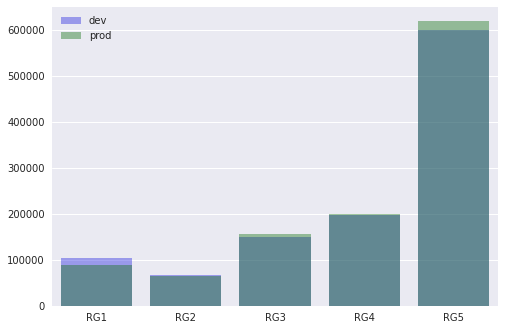

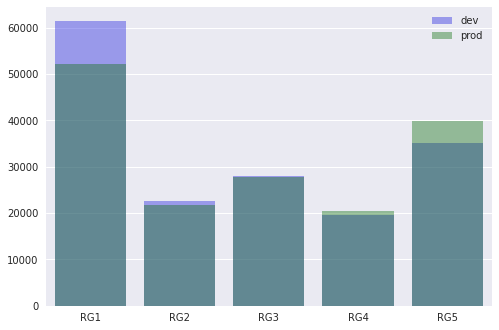

In [20]:
# current model
dev_df_["rg_incumbent"] = get_risk_groups(dev_df_["incumbent_model_score_dev"])
prod_df_["rg_incumbent"] = get_risk_groups(prod_df_["incumbent_model_score_dev"])

freqs = dev_df_["rg_incumbent"].value_counts().sort_index()
sns.barplot(freqs.index, freqs.values, alpha=0.4, label="dev", color="b")

freqs = prod_df_["rg_incumbent"].value_counts().sort_index()
sns.barplot(freqs.index, freqs.values, alpha=0.4, label="prod", color="g")

plt.legend()
plt.show()

active_ids = dev_df_[
        (dev_df_.nr_past_transactions > 0) & (dev_df_.nr_transactions_30d > 0)
    ].user_id.unique()

freqs = dev_df_[dev_df_.user_id.isin(active_ids)]["rg_incumbent"].value_counts().sort_index()
sns.barplot(freqs.index, freqs.values, alpha=0.4, label="dev", color="b")

freqs = prod_df_[prod_df_.user_id.isin(active_ids)]["rg_incumbent"].value_counts().sort_index()
sns.barplot(freqs.index, freqs.values, alpha=0.4, label="prod", color="g")

plt.legend()
plt.show()

In [21]:
def get_rmse(s):
    return math.sqrt((s**2).mean())

print("all population: dev vs prod")
diff = df_.score_dev_data_dev_model - df_.score_prod_data_prod_model
display(get_rmse(diff))

print("all population: incumbent dev vs prod")
diff = df_.incumbent_model_dev_data - df_.incumbent_model_prod_data
display(get_rmse(diff))

# actigve: 
print("active population: dev vs. prod")
df__ = df_[df_.user_id.isin(active_ids)]
diff = df__.score_dev_data_dev_model - df__.score_prod_data_prod_model
display(get_rmse(diff))

print("active population: incumbent dev vs. prod")
diff = df__.incumbent_model_dev_data - df__.incumbent_model_prod_data
display(get_rmse(diff))


all population: dev vs prod


16.60630507200601

all population: incumbent dev vs prod


17.905631182937572

active population: dev vs. prod


26.931735920265247

active population: incumbent dev vs. prod


28.203691909993363

The risk group shift for the active group is rather large. Look into why

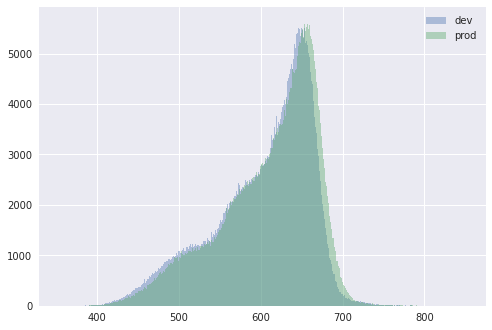

In [22]:
dev_df_.score_dev.hist(bins=1000, alpha=0.4, label="dev")
prod_df_.score_prod.hist(bins=1000, alpha=0.4, label="prod")
plt.legend()

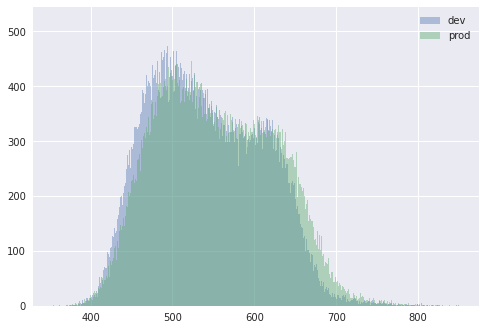

In [23]:
dev_df_[dev_df_.user_id.isin(active_ids)].score_dev.hist(bins=1000, alpha=0.4, label="dev")
prod_df_[prod_df_.user_id.isin(active_ids)].score_prod.hist(bins=1000, alpha=0.4, label="prod")
plt.legend()

In [24]:
df_["is_active"] = df_.user_id.isin(active_ids)

In [25]:
df_.is_active.value_counts()

False    947934
True     161991
Name: is_active, dtype: int64

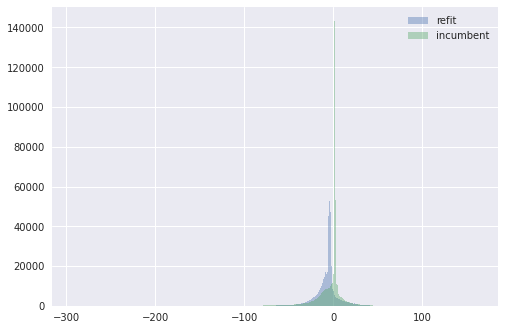

In [26]:
nbins = 1000
(df_.score_dev_data_dev_model - df_.score_prod_data_prod_model).hist(bins=nbins, alpha=0.4, label="refit")
(df_.incumbent_model_dev_data - df_.incumbent_model_prod_data).hist(bins=nbins, alpha=0.4, label="incumbent")
plt.legend()
plt.show()

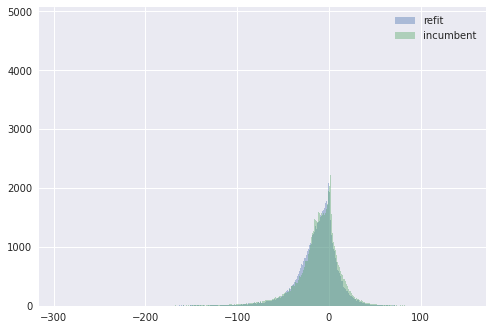

In [27]:
nbins = 1000
(df_[df_.is_active].score_dev_data_dev_model - df_[df_.is_active].score_prod_data_prod_model).hist(bins=nbins, alpha=0.4, label="refit")
(df_[df_.is_active].incumbent_model_dev_data - df_[df_.is_active].incumbent_model_prod_data).hist(bins=nbins, alpha=0.4, label="incumbent")
plt.legend()
plt.show()

In [28]:
df_["score_diff"] = df_.score_dev_data_dev_model - df_.score_prod_data_prod_model
df_tmp = df_[(df_.score_diff.abs() > 100)]
df_tmp.is_active.value_counts()   # active users have more turbulent score differences - why?

True     1409
False     402
Name: is_active, dtype: int64

In [29]:
df_tmp_wf = combined_df[combined_df.user_id.isin(df_tmp.user_id)]

In [30]:
i = 0
dev_row = df_tmp_wf[["user_id"] + col_dev + ["incumbent_model_score_dev_exp"]].iloc[i].rename("dev")
prod_row = df_tmp_wf[["user_id"] + col_prod + ["incumbent_model_score_dev_act"]].iloc[i].rename("prod")
dev_row.index = ["user_id"] + features + ["refit_score", "incumbent_score"]
prod_row.index = ["user_id"] + features + ["refit_score", "incumbent_score"]
df_i = pd.concat([dev_row, prod_row],
                  axis=1)
df_i

,dev,prod
user_id,12447.000000,12447.000000
first_deposit_amount,10.000000,500.000000
vantage_score,NaN,NaN
bcc7120,NaN,NaN
email_risk_score,0.066000,0.066000
fraud_score_2,0.643000,0.643000
name_email_correlation,0.995900,0.995900
transaction_as_pct_of_balance,-0.000025,-1.000000
mean_account_balance_30d,2417.030000,0.000000
phone_risk_score,0.728000,0.728000


In [52]:
fts = ["first_deposit_amount",
       "transaction_as_pct_of_balance",
       "lag_acc_open_first_transaction",
       "nr_past_transactions",
       "time_since_last_transaction", 
       "credit_card_loan_amount"]

i = 2
dev_row = df_tmp_wf[["user_id"] + col_dev + ["incumbent_model_score_dev_exp"]].iloc[i].rename("dev")
prod_row = df_tmp_wf[["user_id"] + col_prod + ["incumbent_model_score_dev_act"]].iloc[i].rename("prod")
dev_row.index = ["user_id"] + features + ["refit_score", "incumbent_score"]
prod_row.index = ["user_id"] + features + ["refit_score", "incumbent_score"]
df_i = pd.concat([dev_row, prod_row],
                  axis=1)
df_i.to_csv("artifacts/uid_17509.csv")

df_i[df_i.index.isin(fts)].to_csv("artifacts/uid_17509_focused_features.csv")

df_i

,dev,prod
user_id,17509.000000,17509.000000
first_deposit_amount,5000.000000,-1.000000
vantage_score,696.000000,696.000000
bcc7120,71.000000,71.000000
email_risk_score,0.607000,0.607000
fraud_score_2,0.142000,0.142000
name_email_correlation,0.010000,0.010000
transaction_as_pct_of_balance,0.006779,0.000000
mean_account_balance_30d,19305.810000,0.000000
phone_risk_score,0.224000,0.224000


mostly transactions data do not align.

In [32]:
# prep dev data
cols_ = ["user_id", "sample_date", "business_account_number",
         "incumbent_model_score_dev", "model_score", "rg_incumbent", "rg_refitted", "is_active"]
dev_df_["is_active"] = dev_df_.user_id.isin(set(active_ids))
display(dev_df_.is_active.value_counts())

df_out = dev_df_[cols_]
df_out.columns = ["user_id", "sample_date", "business_account_number",
                  "score_incumbent", "score_refitted", "rg_incumbent", "rg_refitted", "is_active"]
display(df_out.head())
df_out.to_csv(os.path.join(s3_dir, "20210915-dev-scores.csv"))

False    953129
True     166517
Name: is_active, dtype: int64

,user_id,sample_date,business_account_number,score_incumbent,score_refitted,rg_incumbent,rg_refitted,is_active
8925451,305,2021-09-15,410000276182,574.411334,613.927501,RG4,RG5,False
8925452,361,2021-09-15,410000345005,478.306634,476.012318,RG2,RG1,True
8925453,637,2021-09-15,410000300440,450.108314,471.937248,RG1,RG1,True
8925454,457,2021-09-15,410011645378,503.178169,543.099431,RG2,RG2,False
8925455,468,2021-09-15,410000331898,550.282359,559.857236,RG3,RG3,False


In [33]:
# prep prod data
cols_ = ["user_id", "sample_date",
         "incumbent_model_score_dev", "model_score", "rg_incumbent", "rg_refitted"]
prod_df_.rename({"incumbent_model_score_dev": "score_incumbent",
                "model_score": "score_refitted"}, inplace=True)

df_out = prod_df_[cols_]
df_out.columns = ["user_id", "sample_date",
         "score_incumbent", "score_refitted", "rg_incumbent", "rg_refitted"]
display(df_out.head())

prod_df_[cols_].to_csv(os.path.join(s3_dir, "20210915-prod-scores.csv"))

,user_id,sample_date,score_incumbent,score_refitted,rg_incumbent,rg_refitted
0,3749,2021-09-15,415.193050,467.575063,RG1,RG1
1,13317,2021-09-15,404.635070,466.911229,RG1,RG1
2,14192,2021-09-15,499.297733,549.736468,RG2,RG2
4,32516,2021-09-15,507.394183,537.278439,RG2,RG2
5,33224,2021-09-15,576.250640,608.780491,RG4,RG5


In [34]:
assert dev_df_.model_score.equals(dev_df_.score_dev)
assert prod_df_.model_score.equals(prod_df_.score_prod)

Text(0.5, 1.0, 'Risk Group Shift - july')

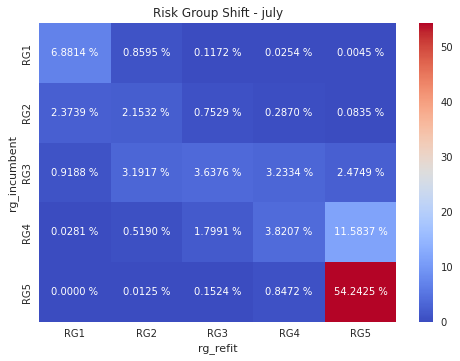

In [35]:
df_["rg_incumbent"] = get_risk_groups(df_["incumbent_model_prod_data"])
df_["rg_refit"] = get_risk_groups_refitted(df_["score_prod_data_prod_model"])

table = df_[["rg_incumbent", "rg_refit"]].value_counts(normalize=True).sort_index().reset_index()
table.columns = ["rg_incumbent", "rg_refit", 'counts']
table = pd.pivot_table(table, values='counts', index="rg_incumbent", 
                       columns="rg_refit", fill_value=0) * 100

hm = sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.4f')
for t in hm.texts: t.set_text(t.get_text() + " %")

plt.title(f'Risk Group Shift - july')

Text(0.5, 1.0, 'Risk Group Shift - dev vs prod')

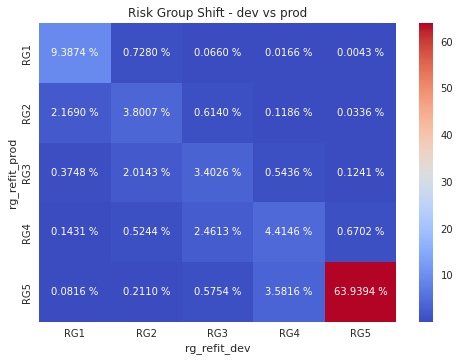

In [36]:
df_["rg_refit_prod"] = get_risk_groups_refitted(df_["score_prod_data_prod_model"])
df_["rg_refit_dev"] = get_risk_groups_refitted(df_["score_dev_data_dev_model"])


table = df_[["rg_refit_prod", "rg_refit_dev"]].value_counts(normalize=True).sort_index().reset_index()
table.columns = ["rg_refit_prod", "rg_refit_dev", 'counts']
table = pd.pivot_table(table, values='counts', index="rg_refit_prod", 
                       columns="rg_refit_dev", fill_value=0) * 100

hm = sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.4f')
for t in hm.texts: t.set_text(t.get_text() + " %")

plt.title(f'Risk Group Shift - dev vs prod')

Text(0.5, 1.0, 'Risk Group Shift - dev vs prod')

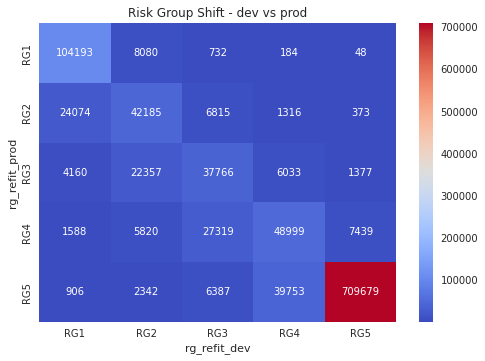

In [37]:
df_["rg_refit_prod"] = get_risk_groups_refitted(df_["score_prod_data_prod_model"])
df_["rg_refit_dev"] = get_risk_groups_refitted(df_["score_dev_data_dev_model"])


table = df_[["rg_refit_prod", "rg_refit_dev"]].value_counts(normalize=False).sort_index().reset_index()
table.columns = ["rg_refit_prod", "rg_refit_dev", 'counts']
table = pd.pivot_table(table, values='counts', index="rg_refit_prod", 
                       columns="rg_refit_dev", fill_value=0) 

hm = sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.0f')

plt.title(f'Risk Group Shift - dev vs prod')

Text(0.5, 1.0, 'Risk Group Shift - dev vs prod')

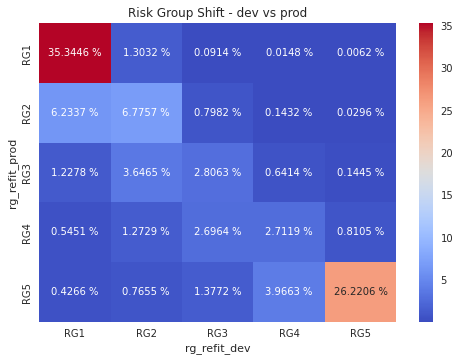

In [42]:
df_["rg_refit_prod"] = get_risk_groups_refitted(df_["score_prod_data_prod_model"])
df_["rg_refit_dev"] = get_risk_groups_refitted(df_["score_dev_data_dev_model"])


table = df_[df_.is_active][["rg_refit_prod", "rg_refit_dev"]].value_counts(normalize=True).sort_index().reset_index()
table.columns = ["rg_refit_prod", "rg_refit_dev", 'counts']
table = pd.pivot_table(table, values='counts', index="rg_refit_prod", 
                       columns="rg_refit_dev", fill_value=0) * 100

hm = sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.4f')
for t in hm.texts: t.set_text(t.get_text() + " %")

plt.title(f'Risk Group Shift - dev vs prod')

Text(0.5, 1.0, 'Risk Group Shift - dev vs prod')

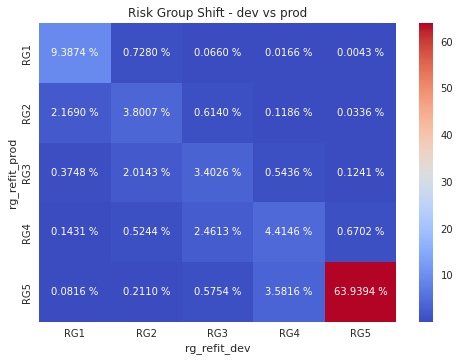

In [38]:
df_["rg_refit_prod"] = get_risk_groups_refitted(df_["score_prod_data_prod_model"])
df_["rg_refit_dev"] = get_risk_groups_refitted(df_["score_dev_data_dev_model"])


table = df_[["rg_refit_prod", "rg_refit_dev"]].value_counts(normalize=True).sort_index().reset_index()
table.columns = ["rg_refit_prod", "rg_refit_dev", 'counts']
table = pd.pivot_table(table, values='counts', index="rg_refit_prod", 
                       columns="rg_refit_dev", fill_value=0) * 100

hm = sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.4f')
for t in hm.texts: t.set_text(t.get_text() + " %")

plt.title(f'Risk Group Shift - dev vs prod')

In [51]:
fts = ["first_deposit_amount",
       "transaction_as_pct_of_balance",
       "lag_acc_open_first_transaction",
       "nr_past_transactions",
       "time_since_last_transaction", 
       "credit_card_loan_amount"]

i = 0
dev_row = df_tmp_wf[["user_id"] + col_dev + ["incumbent_model_score_dev_exp"]].iloc[i].rename("dev")
prod_row = df_tmp_wf[["user_id"] + col_prod + ["incumbent_model_score_dev_act"]].iloc[i].rename("prod")
dev_row.index = ["user_id"] + features + ["refit_score", "incumbent_score"]
prod_row.index = ["user_id"] + features + ["refit_score", "incumbent_score"]
df_i = pd.concat([dev_row, prod_row],
                  axis=1)
df_i.to_csv("artifacts/uid_12447.csv")
df_i[df_i.index.isin(fts)].to_csv("artifacts/uid_12447_focused_features.csv")

df_i

,dev,prod
user_id,12447.000000,12447.000000
first_deposit_amount,10.000000,500.000000
vantage_score,NaN,NaN
bcc7120,NaN,NaN
email_risk_score,0.066000,0.066000
fraud_score_2,0.643000,0.643000
name_email_correlation,0.995900,0.995900
transaction_as_pct_of_balance,-0.000025,-1.000000
mean_account_balance_30d,2417.030000,0.000000
phone_risk_score,0.728000,0.728000


In [53]:
# features misaligned
fts = ["first_deposit_amount",
       "transaction_as_pct_of_balance",
       "lag_acc_open_first_transaction",
       "nr_past_transactions",
       "time_since_last_transaction", 
       "credit_card_loan_amount",
       "mean_account_balance_30d"]

In [54]:
df_i.loc[fts]

,dev,prod
first_deposit_amount,5000.000000,-1.0
transaction_as_pct_of_balance,0.006779,0.0
lag_acc_open_first_transaction,9.000000,-1.0
nr_past_transactions,20.000000,-1.0
time_since_last_transaction,5.000000,-1.0
credit_card_loan_amount,22970.000000,21174.0
mean_account_balance_30d,19305.810000,0.0


In [55]:
psi_tbl_all[psi_tbl_all.feature.isin(fts)]

,feature,psi
15,nr_past_transactions,0.559
6,transaction_as_pct_of_balance,0.111
26,time_since_last_transaction,0.028
35,credit_card_loan_amount,0.004
0,first_deposit_amount,0.001
7,mean_account_balance_30d,0.000
11,lag_acc_open_first_transaction,0.000


#### Find out the impact of features not aligned
---

* User id: 12447
    * Mean account balance  (rank 4)
    * First deposit amount  - filtering or ordering  (rank 1)
    * transaction_as_pct_of_balance  (rank 6)
    * lag_acc_open_first_transaction  (rank 14)
    * nr_past_transactions  (rank 16)
    * time_since_last_transaction  (rank -6)
    * credit_card_loan_amount  (rank 7)


* data monitoring
    * source 
    * 


* dev: ACHDD - ACHDDIN
* according to Arpit, the user has remained dormant since 2020 dec.
    * `transaction_as_pct_of_balance` in dev does not make sense
    * the transaction history does not really make sense

In [100]:
trnx = pd.read_feather("../../data/raw/raw_1632854535/transactions_1632854535.feather")

In [106]:
udf = trnx[trnx.user_id==12447]
udf.shape

(257, 15)

In [108]:
udf.sort_values("created_dt").head()

,tjd,time,business_account_number,created_dt,endbal,transaction_code,transaction_amount,is_credit,user_id,external_account_number,external_institution_id,originating_company_id,external_institution_trans_id,originator_dfi_id,merchant_name
25169449,2018-08-29,19:08:40,410000157616,2018-08-29,10.0,ACHDD,10,1,12447,7001663652,256074974,,,,None
25170005,2018-08-31,00:03:42,410000157616,2018-09-01,10.0,IIPD,0,1,12447,,,,,,None
25172453,2018-09-14,05:47:31,410000157616,2018-09-14,510.0,ACHDDIN,500,1,12447,,,11120908,190302,09140859,None
7639945,2018-09-16,22:43:27,410000157616,2018-09-16,288.5,POSDW,21.50,0,12447,,,,,,GOAT HILL TAVERN
13583901,2018-09-16,14:53:06,410000157616,2018-09-16,305.0,DWATM,205.00,0,12447,,,,,,E39 - LB VET-313320


It apperas the prod env's first transaction is row 3, instead of row 1

In [109]:
udf.sort_values("created_dt").tail()

,tjd,time,business_account_number,created_dt,endbal,transaction_code,transaction_amount,is_credit,user_id,external_account_number,external_institution_id,originating_company_id,external_institution_trans_id,originator_dfi_id,merchant_name
28424885,2020-10-05,18:01:06,410000157616,2020-10-05,460.15,ACHDD,150,1,12447,7001663652,256074974,,,,None
28496475,2020-10-13,18:01:06,410000157616,2020-10-13,500.15,ACHDD,40,1,12447,7001663652,256074974,,,,None
38923900,2020-10-16,18:01:06,410000157616,2020-10-16,600.15,ACHDD,100,1,12447,7001663652,256074974,,,,None
28904773,2020-11-16,18:01:12,410000157616,2020-11-16,0.00,ACHDW,600.26,0,12447,7001663652,256074974,,,,None
39521244,2020-12-09,18:01:11,410000157616,2020-12-09,0.00,ACHDW,.06,0,12447,7001663652,256074974,,,,None


In [110]:
# features df
fdf = pd.read_feather("../../data/labeled/labeled_1633038165.feather")

In [111]:
fdf.shape

(8832730, 103)

In [112]:
ufdf = fdf[fdf.user_id == 12447]